# Sentiment Analysis


## 1. Importing the libraries


In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
import re
nltk.download('punkt')
nltk.download('stopwords')

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Representing text as numerical data


In [197]:
# example text for model training (SMS messages)
simple_train = ['call you tonight',
                'Call me a cab', 'Please call me... PLEASE!']

In [198]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

# learn the 'vocabulary' of the training data (occurs in-place)
vect.fit(simple_train)

# examine the fitted vocabulary
vect.get_feature_names_out()

array(['cab', 'call', 'me', 'please', 'tonight', 'you'], dtype=object)

In [199]:
# transform training data into a 'document-term matrix'
simple_train_dtm = vect.transform(simple_train)
simple_train_dtm

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [200]:
# convert sparse matrix to a dense matrix
simple_train_dtm.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]], dtype=int64)

In [201]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_train_dtm.toarray(), columns=vect.get_feature_names())

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


In [202]:
# check the type of the document-term matrix
print(type(simple_train_dtm))

# examine the sparse matrix contents
print(simple_train_dtm)

<class 'scipy.sparse._csr.csr_matrix'>
  (0, 1)	1
  (0, 4)	1
  (0, 5)	1
  (1, 0)	1
  (1, 1)	1
  (1, 2)	1
  (2, 1)	1
  (2, 2)	1
  (2, 3)	2


In [203]:
# example text for model testing
simple_test = ["please don't call me"]

In [204]:
# transform testing data into a document-term matrix (using existing vocabulary)
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]], dtype=int64)

In [205]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names_out())

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


### Summary

- `vect.fit(train)` **learns the vocabulary** of the training data
- `vect.transform(train)` uses the **fitted vocabulary** to build a document-term matrix from the training data
- `vect.transform(test)` uses the **fitted vocabulary** to build a document-term matrix from the testing data (and ignores tokens it hasn't seen before)


## 2. Reading a text-based dataset into pandas


In [206]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [207]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [208]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [209]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [210]:
train = train.dropna()  # drop missing values

In [211]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [212]:
# Remove textID and selected_text columns
train = train.drop(['textID', 'selected_text'], axis=1)
test = test.drop(['textID'], axis=1)

In [213]:
train.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [214]:
test.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


In [215]:
train.describe()

,text,sentiment
count,27480,27480
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11117


In [216]:
train.groupby('sentiment').describe()

text                                                            \
           count unique                                                top   
sentiment                                                                    
negative    7781   7781      Sooo SAD I will miss you here in San Diego!!!   
neutral    11117  11117                I`d have responded, if I were going   
positive    8582   8582  2am feedings for the baby are fun when he is a...   

                
          freq  
sentiment       
negative     1  
neutral      1  
positive     1

In [217]:
# Convert label to a numerical variable
train['sentiment_num'] = train.sentiment.map(
    {'positive': 0, 'neutral': 1, 'negative': 2})
train.head()

,text,sentiment,sentiment_num
0,"I`d have responded, if I were going",neutral,1
1,Sooo SAD I will miss you here in San Diego!!!,negative,2
2,my boss is bullying me...,negative,2
3,what interview! leave me alone,negative,2
4,"Sons of ****, why couldn`t they put them on t...",negative,2


In [218]:
test['sentiment_num'] = test.sentiment.map(
    {'positive': 0, 'neutral': 1, 'negative': 2})
test.head()

,text,sentiment,sentiment_num
0,Last session of the day http://twitpic.com/67ezh,neutral,1
1,Shanghai is also really exciting (precisely -...,positive,0
2,"Recession hit Veronique Branquinho, she has to...",negative,2
3,happy bday!,positive,0
4,http://twitpic.com/4w75p - I like it!!,positive,0


In [219]:
train["message_length"] = train["text"].apply(len)
train.head()

,text,sentiment,sentiment_num,message_length
0,"I`d have responded, if I were going",neutral,1,36
1,Sooo SAD I will miss you here in San Diego!!!,negative,2,46
2,my boss is bullying me...,negative,2,25
3,what interview! leave me alone,negative,2,31
4,"Sons of ****, why couldn`t they put them on t...",negative,2,75


Text(0.5, 0, 'Message Length')

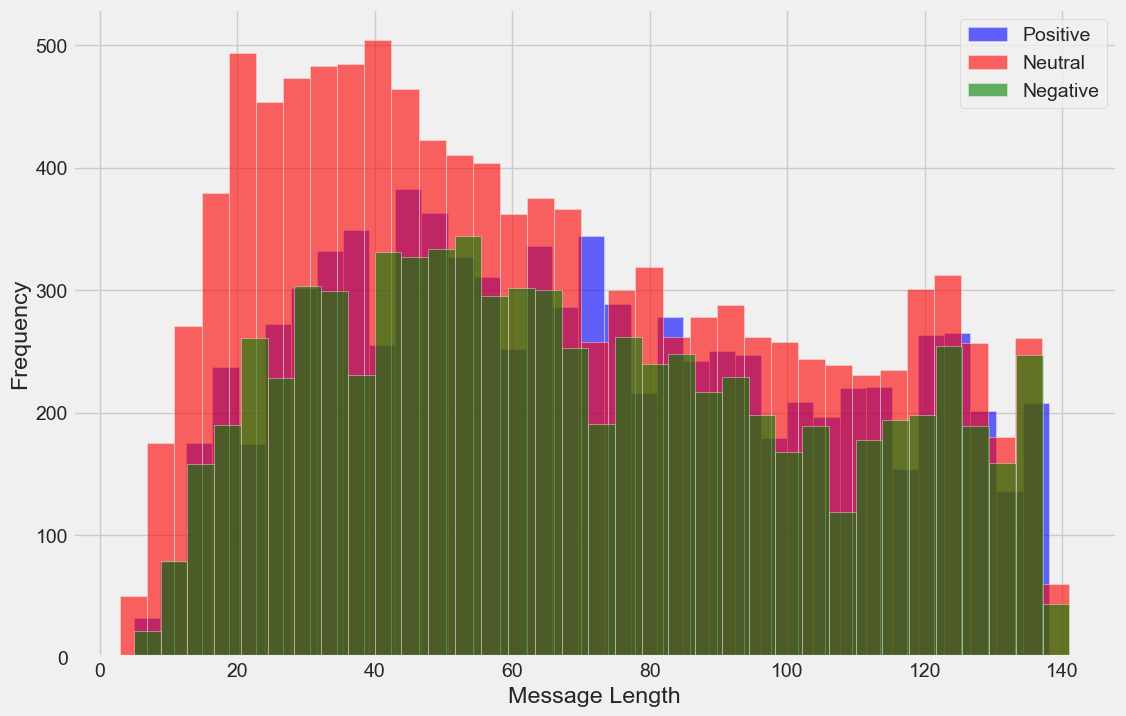

In [220]:
plt.figure(figsize=(12, 8))
train[train.sentiment == 'positive'].message_length.plot(
    bins=35, kind='hist', color='blue', label='Positive', alpha=0.6)
train[train.sentiment == 'neutral'].message_length.plot(
    bins=35, kind='hist', color='red', label='Neutral', alpha=0.6)
train[train.sentiment == 'negative'].message_length.plot(
    bins=35, kind='hist', color='green', label='Negative', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

## 3. Text preprocessing


In [221]:
def text_process(message):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Remove links (HTTP, //, etc.)
    4. Convert all text to lowercase
    5. Remove short words (e.g., words with 2 or fewer characters)
    6. Returns a cleaned string
    """

    STOPWORDS = set(stopwords.words('english')).union(
        ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

    # Remove links using regular expressions
    message = re.sub(r'http\S+', '', message)  # Remove HTTP links
    message = re.sub(r'www\.\S+', '', message)   # Remove www links
    message = re.sub(r'\/\/\S+', '', message)    # Remove // links
    message = re.sub('\[.*?\]', '', message)
    message = re.sub('https?://\S+|www\.\S+', '', message)
    message = re.sub('<.*?>+', '', message)
    message = re.sub('[%s]' % re.escape(string.punctuation), '', message)
    message = re.sub('\n', '', message)
    message = re.sub('\w*\d\w*', '', message)

    # Tokenize the text
    words = word_tokenize(message)

    # Check characters to see if they are in punctuation
    nopunc = [word for word in words if word not in string.punctuation]

    # Convert the text to lowercase and remove short words
    cleaned_words = [word.lower() for word in nopunc if len(word) > 2]

    # Now just remove any stopwords and return a cleaned string
    return ' '.join([word for word in cleaned_words if word not in STOPWORDS])

In [222]:
train.head()

,text,sentiment,sentiment_num,message_length
0,"I`d have responded, if I were going",neutral,1,36
1,Sooo SAD I will miss you here in San Diego!!!,negative,2,46
2,my boss is bullying me...,negative,2,25
3,what interview! leave me alone,negative,2,31
4,"Sons of ****, why couldn`t they put them on t...",negative,2,75


In [223]:
train["clean_text"] = train["text"].apply(text_process)
train.head()

,text,sentiment,sentiment_num,message_length,clean_text
0,"I`d have responded, if I were going",neutral,1,36,responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,2,46,sooo sad miss san diego
2,my boss is bullying me...,negative,2,25,boss bullying
3,what interview! leave me alone,negative,2,31,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,2,75,sons couldnt put releases already bought


In [224]:
test["clean_text"] = test["text"].apply(text_process)
test.head()

,text,sentiment,sentiment_num,clean_text
0,Last session of the day http://twitpic.com/67ezh,neutral,1,last session day
1,Shanghai is also really exciting (precisely -...,positive,0,shanghai also really exciting precisely skyscr...
2,"Recession hit Veronique Branquinho, she has to...",negative,2,recession hit veronique branquinho quit compan...
3,happy bday!,positive,0,happy bday
4,http://twitpic.com/4w75p - I like it!!,positive,0,like


## 4. Vectorizing our dataset


In [225]:
from sklearn.model_selection import train_test_split

X = train['clean_text']
y = train['sentiment_num']
# X_train, X_test, y_train, y_test = train_test_split(
# X, y, test_size=0.2, random_state=101)

# Full dataset for training
X_train = X
y_train = y

# Test dataset
X_test = test['clean_text']
y_test = test['sentiment_num']

print(f"X: {X.shape}")
print(f"y: {y.shape}")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X: (27480,)
y: (27480,)
X_train: (27480,)
X_test: (3534,)
y_train: (27480,)
y_test: (3534,)


In [226]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer

# Fit the CountVectorizer to the training data
vect = CountVectorizer()
vect.fit(X_train)

# Save the fitted vocabulary in the current directory
pickle.dump(vect, open("my_vect.pkl", "wb"))

# Load the fitted vocabulary from the current directory
# vect = pickle.load(open("my_vect.pkl", "rb"))


# Learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.transform(X_train)

# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

# examine the document-term matrix
print(type(X_train_dtm), X_train_dtm.shape)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
print(type(X_test_dtm), X_test_dtm.shape)

<class 'scipy.sparse._csr.csr_matrix'> (27480, 25965)
<class 'scipy.sparse._csr.csr_matrix'> (3534, 25965)


In [227]:
from sklearn.feature_extraction.text import TfidfTransformer

# Fit the TfidfTransformer to the training data
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<27480x25965 sparse matrix of type '<class 'numpy.float64'>'
	with 180053 stored elements in Compressed Sparse Row format>

## 5. Building and evaluating a model


In [228]:
# Import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [229]:
# Train the model using X_train_dtm
%time nb.fit(X_train_dtm, y_train)

CPU times: total: 15.6 ms
Wall time: 13 ms


MultinomialNB()

In [230]:
from sklearn import metrics

# Make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# Calculate accuracy of class predictions
print("===== Accuracy =====")
print(metrics.accuracy_score(y_test, y_pred_class))

# Print the confusion matrix
print("===== Confusion Matrix =====")
print(metrics.confusion_matrix(y_test, y_pred_class))

===== Accuracy =====
0.6513865308432372
===== Confusion Matrix =====
[[757 301  45]
 [237 965 228]
 [ 50 371 580]]


### Hyperparameter tuning to find the best model


In [231]:
from sklearn.model_selection import GridSearchCV

# Define a range of hyperparameters to search over
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],  # Adjust the alpha hyperparameter
    'fit_prior': [True, False],  # Whether to learn class prior probabilities
}

# Create a GridSearchCV object with your model and parameter grid
grid_search = GridSearchCV(
    MultinomialNB(), param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to your training data
grid_search.fit(X_train_dtm, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Evaluate the best model on your test data
y_pred = best_model.predict(X_test_dtm)

# Calculate accuracy of class predictions
print("===== Accuracy =====")
print(metrics.accuracy_score(y_test, y_pred))

# Print the confusion matrix
print("===== Confusion Matrix =====")
print(metrics.confusion_matrix(y_test, y_pred))

Best Hyperparameters: {'alpha': 2.0, 'fit_prior': True}
===== Accuracy =====
0.6590265987549518
===== Confusion Matrix =====
[[ 750  324   29]
 [ 220 1041  169]
 [  48  415  538]]


### Saving the best model


In [232]:
import joblib
import time
joblib.dump(nb, f"my_best_sentiment_model_{time.time()}.sav")

['my_best_sentiment_model_1695647318.9605517.sav']

### Other


In [233]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

# Create a pipeline
pipe = Pipeline([
    # strings to token integer counts
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('model', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

# Calculate accuracy of class predictions
print("===== Accuracy =====")
print(metrics.accuracy_score(y_test, y_pred))

# Print the confusion matrix
print("===== Confusion Matrix =====")
print(metrics.confusion_matrix(y_test, y_pred))

===== Accuracy =====
0.6327108092812677
===== Confusion Matrix =====
[[ 647  434   22]
 [ 163 1158  109]
 [  32  538  431]]
